# Convert meta-data description to NIAGADS xlsx format

**Author: Xuanhe Chen; Edited: Gao Wang**

This notebook serves as a tool to convert human-read-friendly markdown documentation of meta-data descriptor and individual CSV data tables into NIAGADS required xlsx format.

## Motivation

The NIAGADS required metadata file is in xlsx format with multiple sheets, each contains tables in different structure. In previous experience of building this metadata, we realized it is not only hard to type it and edit it manually in spreadsheets software, but also not easy to read. So we decide to keep meta-data in Markdown format, and developed this tool to allow people to convert human-readable Markdown documentation into the final spreadsheets ready for NIAGADS submission. The markdown format allows additional information not part of the original xlsx file requirement but contain useful knowledge about the data and the analysis steps to serve as a complete documentation about a data-set.

## Examples

***NOTE: The excel export require xlsx writer, if it is not downloaded in the environment, plese run "pip install xlsxwriter" before running this notebook.***

### "File Schema" sheet conversion example

(shortened from real metadata for simplicity)

Converted excel sheet:

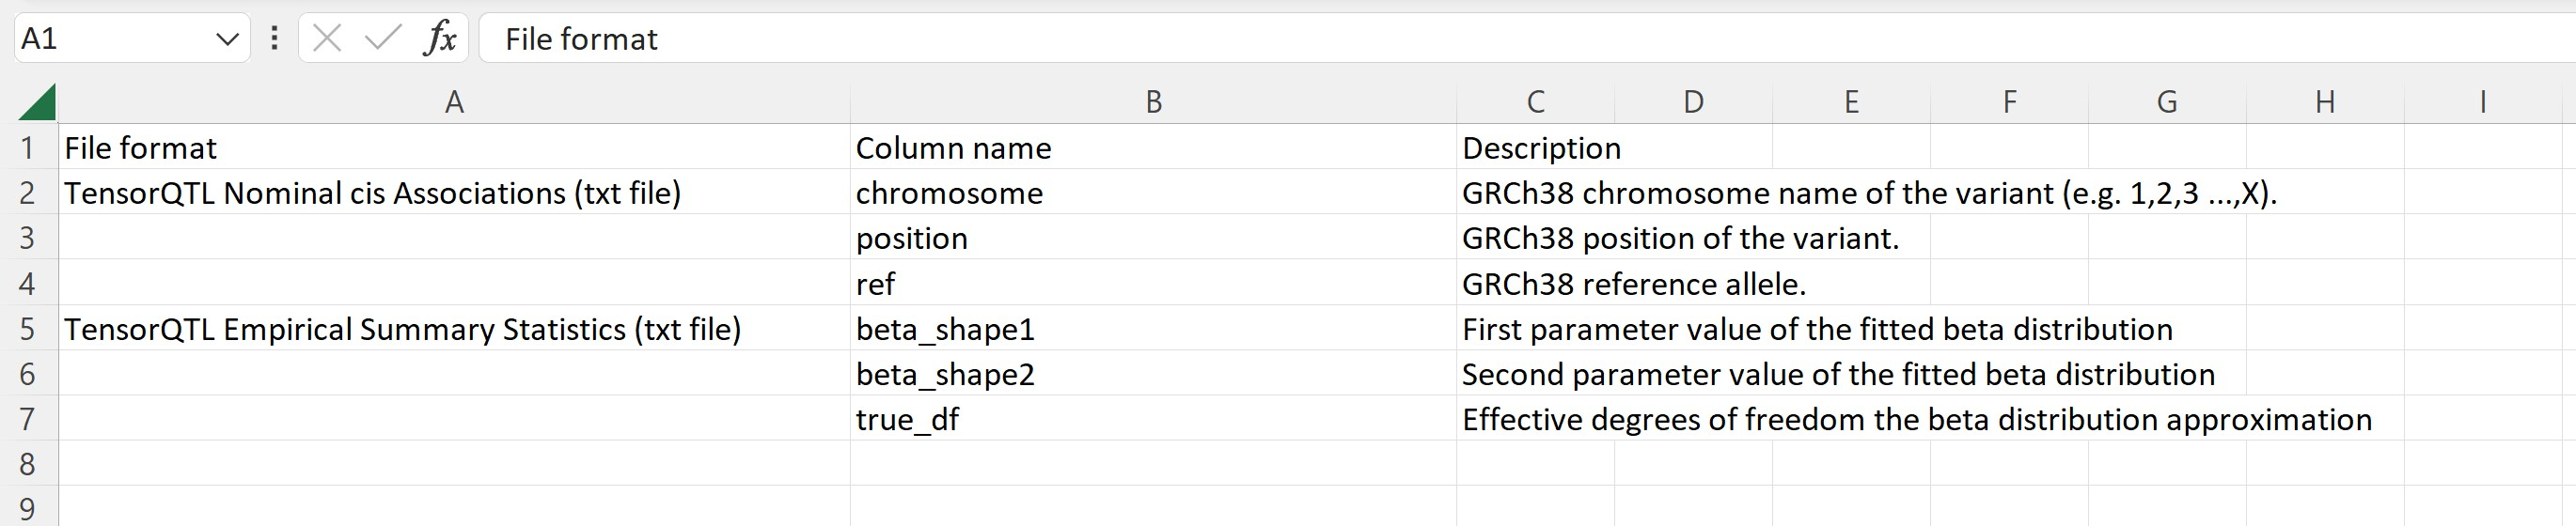

### "Study" sheet conversion example

MD text:

Converted excel sheet:

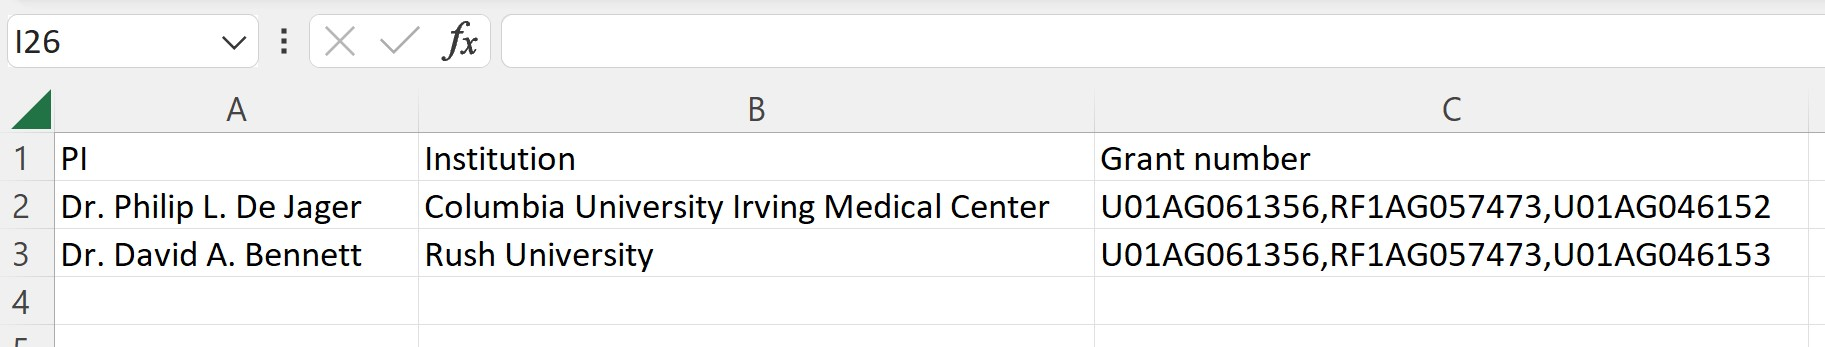

## Markdown Documentation Templates

- [study_descriptor_template](study_descriptorhttps://github.com/cumc/fungen-xqtl-analysis/blob/main/data/template/study_descriptor.md)
    - Currently the code is using "- column name : information 1; information two." as input of each row, so please avoid using " : " (have space before and after the colon) and "; " (have one space after the semicolon) in the text.
- [omics_descriptor_template](https://github.com/cumc/fungen-xqtl-analysis/blob/main/data/template/omics_descriptor.md)
- [QTL_descriptor_template](https://github.com/cumc/fungen-xqtl-analysis/blob/main/data/template/QTL_descriptor.md)

## Code Usage Example

- Please run this code under the data folder linked to [fungen-xqtl-analysis repo](https://github.com/cumc/fungen-xqtl-analysis) to avoid unnecessary conflicts.
- The output metadata will be named as {prefix}_metadata.xlsx, plese use the prefix option to specify your analysis name.

In [ ]:
sos run md_to_niagads.ipynb \
    --omics descriptor/omics/ROSMAP_DLPFC_ChIPSeq_H3K9ac.md \
    --qtl descriptor/qtl/ROSMAP_DLPFC_ChIPSeq_H3K9ac_qtl.md \
    --output_dir NIAGADS

## Workflow

In [18]:
[default]
parameter: cwd = path(".")
parameter: omics = path
parameter: qtl = path
parameter: prefix = f"{qtl:bn}"
parameter: output_dir = path()
# Software container option
parameter: container = ""
cwd = path(f'{cwd:a}')
#
output: f'{output_dir}/{prefix}_metadata.xlsx' 
python: expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container=container
    import markdown
    import ast
    import csv
    import pandas as pd
    import os

    def replaceXwithY(string, pattern, replaceWith):
        return string.replace(pattern, replaceWith)

    # replace html symbols with "" and , as devider for nested list
    def prepare_string_for_nlist(string):
        string = replaceXwithY(string,'</h2><h2>','","')
        string = replaceXwithY(string,'<h2>','"')
        string = replaceXwithY(string,'</h2><li>','","')
        string = replaceXwithY(string,'</h2>','"')
        string = replaceXwithY(string,' : ','","')
        string = replaceXwithY(string,'<li>','"')
        string = replaceXwithY(string,'</li>','"')
        return string

    # convert html_markdown to nested list (not using dictionary since this will be easier to add blank cells)
    def md_to_nlist(input_list):
        temp_str = ''
        temp_list = []
        temp_list2 = []
    
        tlist = input_list.split('\n')
    
        for item in tlist:
            if item.startswith('<h2>'):
                temp_str = temp_str + item
            if item.startswith('<li>'):
                temp_str = temp_str + item
                temp_list.append(temp_str)
                temp_str = ''
            
        for item in temp_list:
            if item.startswith('<h2>'):
                temp_list2.append(prepare_string_for_nlist(item))
            if item.startswith('<li>'):
                temp_list2.append(prepare_string_for_nlist(item))
            
        nlist = [list(ast.literal_eval(x)) for x in temp_list2]
    
        return nlist

    # This function gets path of files in the study overview section a input md
    def get_paths(input_list):
        input_list = (input_list.split('<h2>Study Overview</h2>'))[1].split('<h2>Dataset Description</h2>')[0]
        tlist = input_list.split('\n')
        tlist = [x for x in tlist if x.startswith('<li>')]
    
        file_paths = []
        for item in tlist:
            file_paths.append((item.split('<code>'))[1].split('</code>')[0])
    
        return file_paths

    # This function convert study md to dataframe in required format
    def build_study_sheet(input_study, input_omics, website_info):
    
        study_info = md_to_nlist(input_study)
        study_info[9] = md_to_nlist(website_info)[0]

        study_lines = []
        temp = []

        for item in study_info:
            for sub_item in item:
                temp.append(sub_item.split('; '))
            study_lines.append(temp)
            temp = []
    
        study_lines_flatten = []
        for item in study_lines:
            study_lines_flatten.append([i for sublist in item for i in sublist])
    
        study_lines_space_replaced = []
        temp2 = []

        for item in study_lines_flatten:
            for sub_item in item:
                if item.index(sub_item) == 0:
                    temp2.append(sub_item.replace(' ', '_'))
                else:
                    temp2.append(sub_item)
            study_lines_space_replaced.append(temp2)
            temp2 = []
        
        omics_md = input_omics.split('<h2>Contact</h2>')[0]
        temp3 = omics_md.split('\n')
        Dataset_name = temp3[0]
        Dataset_description = temp3[1]
        Dataset_name = replaceXwithY(Dataset_name,'<h1>','')
        Dataset_name = replaceXwithY(Dataset_name,'</h1>','')
        Dataset_description = replaceXwithY(Dataset_description,'<p>','')
        Dataset_description = replaceXwithY(Dataset_description,'</p>','')
    
        Dataset_name = ['Dataset_name', Dataset_name]
        Dataset_description = ['Dataset_description', Dataset_description]
    
        study_lines_space_replaced.insert(8, Dataset_name)
        study_lines_space_replaced.insert(9, Dataset_description)
    
        df = pd.DataFrame(study_lines_space_replaced).T
        df = df.replace('&amp;','&', regex=True)
        df = df.fillna(method='ffill')
    
        return df

    # This function convert file schema md to dataframe in required format
    def build_schema_sheet(input_schema):
    
        schema_info = md_to_nlist(input_schema)
        del schema_info[0][0]
    
        schema_lines = []

        for item in schema_info:
            if len(item) == 2:
                schema_lines.append([''] + item)
            else:
                schema_lines.append(item)
    
        schema_lines_space_replaced = []
        temp = []

        for item in schema_lines:
            for sub_item in item:
                if item.index(sub_item) == 1:
                    temp.append(sub_item.replace(' ', '_'))
                else:
                    temp.append(sub_item)
            schema_lines_space_replaced.append(temp)
            temp = []
        
        schema_lines_space_replaced = [['File format', 'Column name', 'Description']] + schema_lines_space_replaced

        df = pd.DataFrame(schema_lines_space_replaced)
    
        return df

    # Parse study information
    input_omics = open('${omics}', 'r')
    omics_md = markdown.markdown(input_omics.read())
    input_qtl = open('${qtl}', 'r')
    qtl_md = markdown.markdown(input_qtl.read())

    omics_file_list = (omics_md.split('<h2>Study Overview</h2>'))[1].split('<h2>Dataset Description</h2>')[0]
    tlist = omics_file_list.split('\n')
    tlist = [x for x in tlist if x.startswith('<li>')]

    # get list of datasets the analysis used
    study_files = tlist[0]
    study_files = study_files.split('<code>')
    study_info = []
    for item in study_files:
        if item.startswith('<li>'):
            continue
        else:
            study_info.append(item.split('</code>')[0])

    # get url to the particular dataset
    website_info = tlist[1]

    # get tables for metadata
    phenotype = get_paths(qtl_md)[0]
    sample_info = get_paths(qtl_md)[1]
    processing_steps = get_paths(qtl_md)[2]

    # Some simple file checking
    if not os.path.exists(f'${cwd}/{phenotype}'):
        raise Exception(f'file {phenotype} not exist.')
    if not os.path.exists(f'${cwd}/{sample_info}'):
        raise Exception(f'file {sample_info} not exist.')
    if not os.path.exists(f'${cwd}/{processing_steps}'):
        raise Exception(f'file {processing_steps} not exist.')

    # TODO: ignore these files for now but we will check these file in the workflow when people finish these steps
    QTL_summary_statistics = get_paths(qtl_md)[3]
    Fine_mapping_individual_model = get_paths(qtl_md)[4]
    Fine_mapping_results_sumstats_model = get_paths(qtl_md)[5]

    # The file schema is default as the xQTL pipeline output schema for now
    result_schema = f'${cwd}/template/xQTL_sumstats_file_schema.md'

    study_md_list = []
    for item in study_info:
        input_study = open(item, 'r')
        study_md = markdown.markdown(input_study.read())
        study_md = study_md.split('<h2>Data Descriptions</h2>')[0]
        study_md_list.append(study_md)

    # convert list of study md to list of dataframes
    study_list = []
    for item in study_md_list:
        study_list.append(build_study_sheet(item, omics_md, website_info))

    # stack dataframes from different studies
    study_list_first = study_list[0]
    study_list_cond = []
    study_list.pop(0)
    for item in study_list:
        study_list_cond.append(item.tail(-1))

    study = [study_list_first] + study_list_cond
    study = pd.concat(study, axis=0, ignore_index=False)

    # convert file schema md to list of dataframes
    input_schema = open(result_schema, 'r')
    schema_md = markdown.markdown(input_schema.read())
    schema = build_schema_sheet(schema_md)

    # Create the other dataframes from reading csv inputs
    phenotype = pd.read_csv(f'${cwd}/{phenotype}', header=None, keep_default_na=False)
    sample_info = pd.read_csv(f'${cwd}/{sample_info}', header=None, keep_default_na=False)
    processing_steps = pd.read_csv(f'${cwd}/{processing_steps}', header=None, keep_default_na=False)

    # Create a new excel workbook
    writer = pd.ExcelWriter(f'${output_dir}/${prefix}_metadata.xlsx', engine='xlsxwriter')

    # Write each dataframe to a different worksheet.
    study.to_excel(writer, sheet_name='Study', index=False, header=False)
    phenotype.to_excel(writer, sheet_name='Phenotype', index=False, header=False)
    sample_info.to_excel(writer, sheet_name='Sample and Experimental Info', index=False, header=False)
    processing_steps.to_excel(writer, sheet_name='File and Data Processing Steps', index=False, header=False)
    schema.to_excel(writer, sheet_name='File Schema', index=False, header=False)

    # Save workbook
    writer.close()

## Development playground

Codes below are used for testing during the development and can be safely removed at any point.